# Novelty Algo

## Algorithm to Automate Novelty Scoring

### Import Packages

In [93]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from functools import reduce
import openpyxl
import xlsxwriter

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk import ngrams, FreqDist
from nltk.lm import NgramCounter
import string
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from spacy.lang.en.stop_words import STOP_WORDS

from collections import Counter
import itertools

from sklearn.metrics.pairwise import cosine_similarity

from scipy import spatial

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

from nltk.cluster.kmeans import KMeansClusterer

from scipy import stats
from scipy.stats import pearsonr

### Put Data from Excel Sheet into Dataframes

In [2]:
# individual df's for each sheet

# when on pc
data_cup = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_cup_semdis.csv")
data_key = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_key_semdis.csv")
data_rope = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_rope_semdis.csv")
data_brick = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_brick_semdis.csv")
data_chair = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_chair_semdis.csv")
data_pencil = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_pencil_semdis.csv")
data_shoe = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_shoe_semdis.csv")

# when on mac
# data_cup = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_cup_semdis.csv.xlsx")
# data_key = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_key_semdis.csv.xlsx")
# data_rope = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_rope_semdis.csv.xlsx")
# data_brick = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_brick_semdis.csv.xlsx")
# data_chair = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_chair_semdis.csv.xlsx")
# data_pencil = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_pencil_semdis.csv.xlsx")
# data_shoe = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_shoe_semdis.csv.xlsx")

### Preprocessing

In [3]:
# nltk corpus stop words
stopwords_nltk = stopwords.words('english')
# spacy stop words
stopwords_spacy = STOP_WORDS

In [69]:
# method to clean the responses
def process_text(text, stopwords_list, remove_sw, join_list):
    # tokenize text, lemmanize words, removing punctuation, remove stop words, lowercase all words

    # hardcorded for special situations
    text = re.sub("wedging","wedge", text)
    text = re.sub("exersizing","exercise", text)
    text = re.sub("thrown","throw", text)
    text = re.sub("cupping","cup", text)
    text = re.sub("dripping","drip", text)
    text = re.sub("pinata","toy", text)
    text = re.sub("swung","swing", text)
    text = re.sub("tripwire","trip-wire", text)
    text = re.sub("taller","tall", text)
    text = re.sub("pushup","push-up", text)
    text = re.sub("tricep","muscle", text)
    text = re.sub("eraser","erase", text)
    text = re.sub("erasing","erase", text)
    text = re.sub("scraping","scrape", text)
    text = re.sub("stabbing","stab", text)
    text = re.sub("someti|somet","something", text)
    text = re.sub("swatter","swat", text)
    text = re.sub("swatting","swat", text)
    text = re.sub("donating","donate", text)
    text = re.sub("exercising","exercise", text)
    text = re.sub("somethinghing","something", text)
    text = re.sub("doorstop","door-stop", text)
    text = re.sub("tugofwar","tug-of-war", text)
    
    text = re.sub("/|-"," ", text)
    text = text.translate(str.maketrans('','',string.punctuation))
    tokens = word_tokenize(text)

    tokens = [w.lower() for w in tokens]
    
    if remove_sw:
        tokens = [word for word in tokens if word not in stopwords_list]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
#         stemmer = PorterStemmer()
#         tokens = [stemmer.stem(t) for t in tokens]

    if join_list:
        tokens = ' '.join(tokens)
 
    return tokens

### General Functions

In [5]:
# method to get a list of participants
def get_id_list(df):
    id_list = df['id'].unique()
    id_list = sorted(id_list)
    return id_list

In [6]:
# method to add a new column
# new column are cleaned responses
def get_cleaned_responses(df, stopwords_list, remove_sw, join_list):
    # id_df = df[df.id == id]
    df_processed = df.copy(deep=True)
    responses = df['response'].tolist()

    # make list of processed responses
    for response in range(len(responses)):
        responses[response] = process_text(responses[response], stopwords_list, remove_sw, join_list)

    # add list as column in df
    df_processed['response_processed'] = responses

    return df_processed

## Semantic Spaces
### Word2Vec Models for Embeddings

In [7]:
# load pretrained model
word_model_twitter25 = api.load("glove-twitter-25")

# on pc
# word_model_google = KeyedVectors.load_word2vec_format("C:/Users/jhec8/Documents/Northwestern_SROP/GoogleNews-vectors-negative300.bin", binary=True)

# on mac
# word_model = KeyedVectors.load_word2vec_format("/Users/johnhenrycruz/Desktop/Northwestern_SROP/GoogleNews-vectors-negative300.bin", binary=True)

In [8]:
# create dictionary of counts for each word in model
twitter25_dict = {}
for i in range(len(word_model_twitter25)):
    twitter25_dict[word_model_twitter25.index_to_key[i]] = word_model_twitter25.key_to_index[word_model_twitter25.index_to_key[i]]

In [9]:
# get the frequency of each word in dictionary
total_words = 0
for key in twitter25_dict:
    total_words = total_words + twitter25_dict[key]
    
for key in twitter25_dict:
    twitter25_dict[key] = twitter25_dict[key]/total_words

### ukwac Semantic Space

In [10]:
# when on pc
ukwac_sem_space = pd.read_csv('C:/Users/jhec8/Documents/Northwestern_SROP/ukwac.txt', delimiter = " ", header = None)

# when on mac
# ukwac_sem_space = pd.read_csv('/Users/johnhenrycruz/Desktop/Northwestern_SROP/ukwac.txt', delimiter = " ", header = None, encoding='latin-1')

ukwac_sem_space = ukwac_sem_space.set_index(0)


In [11]:
ukwac_sem_space

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
0,,,,,,,,,,,,,,,,,,,,,
</s>,0.001001,0.001105,-0.000958,-0.000820,0.000342,0.000755,0.000235,0.000053,-0.000901,0.000555,...,-0.000453,0.000009,-0.000691,0.000940,0.000957,0.000815,-0.000368,0.000068,0.000201,-0.000671
the,-0.176528,0.498660,-0.025550,0.454070,0.092507,0.258827,0.260747,0.038257,-0.192332,0.095421,...,0.564220,0.647529,0.264421,0.421305,-0.473167,0.263297,-0.287083,-0.617989,0.086042,0.555010
of,-0.363240,0.207356,-0.333181,0.413527,-0.209578,0.184913,0.446834,0.081978,-0.311497,-0.022150,...,0.804674,0.406484,0.318285,0.755942,-0.478414,0.306891,-0.403508,-0.331963,0.466197,-0.090987
and,-0.146118,0.245265,0.104299,0.577452,0.279372,-0.034110,0.538732,0.020955,-0.177831,0.203355,...,0.624485,0.415114,0.078963,0.336975,-0.113582,0.337823,0.022114,0.170854,-0.132418,-0.645895
be,-0.570585,0.099979,0.554887,-0.479883,0.109848,0.445984,-0.144741,0.347022,-0.093665,0.273852,...,-0.290909,0.302652,-0.019503,0.741136,-0.330540,0.271714,-0.176909,-0.547867,0.180331,0.385517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kimball,-1.393728,0.242885,-1.556329,0.715039,-0.752086,-0.345446,-0.675950,1.467655,1.450838,-1.472090,...,1.000873,-0.214721,0.226673,1.376971,1.399388,-0.112408,0.651656,-2.597081,0.640036,-1.219004
carara,0.782913,-0.660991,-0.630007,0.463286,0.316139,-0.427366,-0.341664,0.825662,0.116876,-0.553291,...,0.721038,-0.904994,-0.069005,-1.591310,0.341490,0.514781,0.337910,-0.835041,0.882852,-0.214451
hypoallergenic,-0.042689,-0.959848,1.220912,-0.053766,0.180010,-1.810830,-0.816462,-0.248799,1.480133,0.912481,...,0.165383,-0.456424,-0.927048,1.475945,-0.004872,-1.189443,-0.904367,-0.050912,-1.000301,-0.620995


## Novelty Algo 1
### Avg Distance using Word2Vec
### Lesser Average Similarity, More Novel

In [12]:
# method to get the novelty rating
# average of the similarities seen
def get_similarity_word2vec_avg(prompt, phrase_list, word_model):
    avg_sim = 0
    # find similarity of each word in phrase with the prompt
    for term in range(len(phrase_list)):
        avg_sim = avg_sim + word_model.similarity(w1 = prompt, w2 = phrase_list[term])
        
    # take the average
    if len(phrase_list) == 0:
        avg_sim = 0
    else:
        avg_sim = avg_sim/len(phrase_list)

    return (avg_sim)

In [13]:
# method that returns the dataframe with novelty rating for each phrase
def get_novelty_word2vec_avg(df, prompt, stopwords_list, word_model, remove_sw, join_list):
    # clean the responses
    novel_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    novel_rating_df = novel_rating_df[novel_rating_df.astype(str)['response_processed'] != '[]']
    cleaned_responses = novel_rating_df['response_processed'].tolist()
    avg_sim_list = []

    # implement algo
    # pass in clean responses
    for response in cleaned_responses:
        # add novelty rating to list 
        avg_sim_list.append(get_similarity_word2vec_avg(prompt, response, word_model))

    # add novelty rating list to dataframe
    novel_rating_df['avg_sim'] = avg_sim_list
    
    # new column with novelty rating
    return novel_rating_df

In [14]:
data_brick_novelty_word2vec_avg = get_novelty_word2vec_avg(data_brick, "brick", stopwords_spacy, word_model_twitter25, True, False)
data_brick_novelty_word2vec_avg

,id,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,response_processed,avg_sim
0,1476,as a foundation,foundation,Brick,brick,0.77417,[foundation],0.534983
1,1476,as a weapon,weapon,Brick,brick,0.85011,[weapon],0.630485
2,1476,as a bowl,bowl,Brick,brick,0.82926,[bowl],0.665463
3,1718,build a house,build house,Brick,brick,0.93854,"[build, house]",0.730444
4,1718,break a window,break window,Brick,brick,0.96992,"[break, window]",0.742416
5,1718,line a fireplace,line fireplace,Brick,brick,0.99511,"[line, fireplace]",0.682331
6,1718,line a road,line road,Brick,brick,0.99395,"[line, road]",0.716282
7,1691,build house,build house,Brick,brick,0.93854,"[build, house]",0.730444
8,1691,break window,break window,Brick,brick,0.96992,"[break, window]",0.742416
9,1691,weight for workout,weight workout,Brick,brick,1.05438,"[weight, workout]",0.557236


## Novelty Algo 2
### Word2Vec + Smooth Inverse Frequency + Cosine Similarity

### Does work well because phrases are super short
### Don't use

In [15]:
# method to apply SIF to the vectors 
def get_sif_feature_vectors(prompt, response, word_model):
    # set the word count dictionary with frequencies
    word_counts = twitter25_dict
    # size of vectore in word embeddings
    embedding_size = 25 
    # set hyper parameter
    a = 0.001
    # list to store vectors
    phrase_set = []
    for phrase in [prompt, response]:
        # zero out the vector
        vs = np.zeros(embedding_size)
        phrase_length = len(phrase)
        for word in phrase:
            # smooth inverse frequency, SIF
            a_value = a / (a + word_counts[word]) 
            # vs += sif * word_vector
            vs = np.add(vs, np.multiply(a_value, word_model[word]))
        # weighted average
        if phrase_length == 0:
            vs[:] = 0
        else:
            vs = np.divide(vs, phrase_length) 
        phrase_set.append(vs)
    # return the SIF adjusted vectors
    return phrase_set

In [16]:
# method to calculate cosine similarity
def get_cosine_similarity(feature_vec_1, feature_vec_2):
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

In [17]:
def get_similarity_word2vec_sif_cosinesim(prompt, response, word_model):
    # get the SIF adjusted vectors
    vectors = get_sif_feature_vectors(prompt, response, word_model)
    # return the cosine similarity
    return (1 - get_cosine_similarity(vectors[0], vectors[1]))

In [18]:
def get_novelty_word2vec_sif_cosinesim(df, prompt, stopwords_list, word_model, remove_sw, join_list):
    # clean the responses
    novel_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    novel_rating_df = novel_rating_df[novel_rating_df.astype(str)['response_processed'] != '[]']
    cleaned_responses = novel_rating_df['response_processed'].tolist()
    avg_sim_list = []

    # implement algo
    # pass in clean responses
    for response in cleaned_responses:
        # add novelty rating to list 
        avg_sim_list.append(get_similarity_word2vec_sif_cosinesim(prompt, response, word_model))

    # add novelty rating list to dataframe
    novel_rating_df['SIF + cosine sim'] = avg_sim_list
    
    # new column with novelty rating
    return novel_rating_df

In [19]:
data_brick_novelty_word2vec_sif_cosinesim = get_novelty_word2vec_sif_cosinesim(data_brick, "brick", stopwords_spacy, word_model_twitter25, True, False)
data_brick_novelty_word2vec_sif_cosinesim

,id,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,response_processed,SIF + cosine sim
0,1476,as a foundation,foundation,Brick,brick,0.77417,[foundation],0.563437
1,1476,as a weapon,weapon,Brick,brick,0.85011,[weapon],0.777387
2,1476,as a bowl,bowl,Brick,brick,0.82926,[bowl],0.515435
3,1718,build a house,build house,Brick,brick,0.93854,"[build, house]",0.342759
4,1718,break a window,break window,Brick,brick,0.96992,"[break, window]",0.398735
5,1718,line a fireplace,line fireplace,Brick,brick,0.99511,"[line, fireplace]",0.503658
6,1718,line a road,line road,Brick,brick,0.99395,"[line, road]",0.283702
7,1691,build house,build house,Brick,brick,0.93854,"[build, house]",0.342759
8,1691,break window,break window,Brick,brick,0.96992,"[break, window]",0.398735
9,1691,weight for workout,weight workout,Brick,brick,1.05438,"[weight, workout]",0.582402


## Novelty Algo 3
### ukwac_sem_space + element wise multiplication + cosine distance
### Greater Cos Distance, Greater Novelty

In [20]:
# method to get the element wise multiplied vector
# multiply vectors in phrase
def get_ew_multiplied_vector(phrase_list):
    vectors_list = []
    # add vectors to list
    # change to numpy array
    for term in phrase_list:
        vectors_list.append(np.array(ukwac_sem_space.loc[term].values.tolist()))
    
    # get element wise multiplied vector
    element_wise_multiplied_vector = np.ones(400)

    for vector in vectors_list:
        element_wise_multiplied_vector = element_wise_multiplied_vector * vector

    return element_wise_multiplied_vector

In [21]:
# get cosine sim from prompt and ewm
def get_cosine_sim_ewm(prompt, response):
    prompt_vector = np.array(ukwac_sem_space.loc[prompt].values.tolist())
    ewm_vector = get_ew_multiplied_vector(response)

    return (1 - get_cosine_similarity(prompt_vector, ewm_vector))

In [22]:
# get df with results of the cosine distance from prompt using the elementwise multiplied vectors in the response
def get_novelty_ukwac_ewm_cosinedist(df, prompt, stopwords_list, remove_sw, join_list):
    # clean the responses
    novel_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    novel_rating_df = novel_rating_df[novel_rating_df.astype(str)['response_processed'] != '[]']
    cleaned_responses = novel_rating_df['response_processed'].tolist()
    # list to store cosine sims
    cosine_sim_list = []

    # implement algo
    # pass in clean responses
    for response in cleaned_responses:
        # add novelty rating to list 
        cosine_sim_list.append(get_cosine_sim_ewm(prompt, response))

    # add novelty rating list to dataframe
    novel_rating_df['ewm_vector_cosine_dis'] = cosine_sim_list
    
    # new column with novelty rating
    return novel_rating_df

In [128]:
test1 = np.array(ukwac_sem_space.loc['line'].values.tolist())
test2 = np.array(ukwac_sem_space.loc['road'].values.tolist())
test3 = test1 * test2
test4 = np.array(ukwac_sem_space.loc['brick'].values.tolist())
print(1 - cosine_similarity(test4.reshape(1, -1), test3.reshape(1, -1))[0][0])

0.9762727427995705


In [24]:
data_brick_novelty_ukwac_ewm_cosinedist = get_novelty_ukwac_ewm_cosinedist(data_brick, 'brick', stopwords_spacy, True, False)
data_brick_novelty_ukwac_ewm_cosinedist

,id,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,response_processed,ewm_vector_cosine_dis
0,1476,as a foundation,foundation,Brick,brick,0.77417,[foundation],0.936781
1,1476,as a weapon,weapon,Brick,brick,0.85011,[weapon],0.956177
2,1476,as a bowl,bowl,Brick,brick,0.82926,[bowl],0.779148
3,1718,build a house,build house,Brick,brick,0.93854,"[build, house]",0.955084
4,1718,break a window,break window,Brick,brick,0.96992,"[break, window]",0.978611
5,1718,line a fireplace,line fireplace,Brick,brick,0.99511,"[line, fireplace]",1.043541
6,1718,line a road,line road,Brick,brick,0.99395,"[line, road]",0.976273
7,1691,build house,build house,Brick,brick,0.93854,"[build, house]",0.955084
8,1691,break window,break window,Brick,brick,0.96992,"[break, window]",0.978611
9,1691,weight for workout,weight workout,Brick,brick,1.05438,"[weight, workout]",1.033559


## Novelty Algo 4
### ukwac_sem_space + local minina + cosine distance

In [25]:
# get word in phrase that has the least distance from the prompt
def get_minima_vector_cos_distance(prompt, phrase_list):
    distances_list = []
    # get prompt vector
    prompt_vector = np.array(ukwac_sem_space.loc[prompt].values.tolist())
    
    # create list of cosine distances
    for term in phrase_list:
        distances_list.append((1 - get_cosine_similarity(prompt_vector, np.array(ukwac_sem_space.loc[term].values.tolist()))))
        
    # return the max cosine distance
    return max(distances_list, default=0)

In [47]:
# get df with results of the cosine distance from prompt using the minima vector in the response
def get_novelty_ukwac_minimavec_cosinedist(df, prompt, stopwords_list, remove_sw, join_list):
    # clean the responses
    novel_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    novel_rating_df = novel_rating_df[novel_rating_df.astype(str)['response_processed'] != '[]']
    cleaned_responses = novel_rating_df['response_processed'].tolist()
    # list to store cosine sims
    cosine_sim_list = []

    # implement algo
    # pass in clean responses
    for response in cleaned_responses:
        # add novelty rating to list 
        cosine_sim_list.append(get_minima_vector_cos_distance(prompt, response))

    # add novelty rating list to dataframe
    novel_rating_df['minima_vector_cosine_dis'] = cosine_sim_list
    
    # new column with novelty rating
    return novel_rating_df

In [48]:
data_brick_novelty_ukwac_minimavec_cosinedist = get_novelty_ukwac_minimavec_cosinedist(data_brick, 'brick', stopwords_spacy, True, False)
data_brick_novelty_ukwac_minimavec_cosinedist

,id,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,response_processed,minima_vector_cosine_dis
0,1476,as a foundation,foundation,Brick,brick,0.77417,[foundation],0.936781
1,1476,as a weapon,weapon,Brick,brick,0.85011,[weapon],0.956177
2,1476,as a bowl,bowl,Brick,brick,0.82926,[bowl],0.779148
3,1718,build a house,build house,Brick,brick,0.93854,"[build, house]",0.609464
4,1718,break a window,break window,Brick,brick,0.96992,"[break, window]",0.905654
5,1718,line a fireplace,line fireplace,Brick,brick,0.99511,"[line, fireplace]",0.801291
6,1718,line a road,line road,Brick,brick,0.99395,"[line, road]",0.801291
7,1691,build house,build house,Brick,brick,0.93854,"[build, house]",0.609464
8,1691,break window,break window,Brick,brick,0.96992,"[break, window]",0.905654
9,1691,weight for workout,weight workout,Brick,brick,1.05438,"[weight, workout]",1.022161


## Novelty Algo 5
### ukwac_sem_space + element wise multiplication + cosine distance + clustering
### average responses cosine distance in the same cluster
### idea is that phrases with same alternate task will group
### variation in phrase in the same cluster will  be averaged out

In [123]:
def get_counts_vector(num_clusters, responses):
    # initialize CountVectorizer object
    count_vectorizer = CountVectorizer()
    # vectorize the phrases
    word_count = count_vectorizer.fit_transform(responses)
    
    # elbow method to visualize and find out how many clusters to use
    visualizer = KElbowVisualizer(KMeans(), k=(10,35), timings=False)
    visualizer.fit(word_count.toarray())       
#     visualizer.show()

    # nltk kmeans cosine distance implementation
    number_of_clusters = num_clusters
    kmeans = KMeansClusterer(number_of_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters=True)
    assigned_clusters = kmeans.cluster(word_count.toarray(), assign_clusters=True)

    # scikit-learn euclidean distance implementation
#     kmeans = KMeans(n_clusters = num_clusters).fit(word_count)
        
    # cluster results scikit-learn
    results = pd.DataFrame()
    results['text'] = responses
#     results['category'] = kmeans.labels_
    results['category'] = assigned_clusters
    
    # create dictionary to organize the clusters with their respective phrases
    results_dict = {k: g["text"].tolist() for k,g in results.groupby("category")}
    
    # df of the clusters and the 
    clusters_df = pd.DataFrame(list(results_dict.items()),columns = ['category','responses']) 
    
    return clusters_df

In [132]:
def get_clustered_novelty_score(novel_rating_df, column):
    # get cluster df
    clusters_df = get_counts_vector(22, novel_rating_df['response_processed_phrase'].tolist())
    # get cleaned phrases and their current novelty rating
    novelty_scores = dict(zip(novel_rating_df.response_processed_phrase, novel_rating_df[column]))

    # create dictionary out of cluster df
    clusters = dict(zip(clusters_df.category, clusters_df.responses))
        
    # initialize empty dictionary to store the score for a category
    clusters_scores = dict.fromkeys(clusters)
    
    # get the average cosine distance for a cluster
    for key in clusters:
        score = 0
        for phrase in clusters[key]:
            score = score + novelty_scores[phrase]
        score = score/len(clusters[key])
        clusters_scores[key] = score
        
    # create dictionary to store a phrase and its new novelty score 
    # new score is the average of the responses in one cluster
    phrase_scores_dict = {}
    for key in clusters:
        for phrase in clusters[key]:
            phrase_scores_dict[phrase] = clusters_scores[key]
            
    # make a list that matches the one in the current dataframe
    # return list to be added to dataframe
    df_phrases_scores_list = [] 
    for phrase in novel_rating_df['response_processed_phrase'].tolist():
        df_phrases_scores_list.append(phrase_scores_dict[phrase])
    
    # uncomment to show clusters df
#     display(clusters_df)
            
    return list(df_phrases_scores_list)

In [133]:
# get df with results of the cosine distance from prompt using the elementwise multiplied vectors in the response
def get_novelty_ukwac_ewm_cosinedist_cluster(df, prompt, stopwords_list, remove_sw, join_list):
    # clean the responses
    novel_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    novel_rating_df = novel_rating_df[novel_rating_df.astype(str)['response_processed'] != '[]']
    cleaned_responses = novel_rating_df['response_processed'].tolist()
    novel_rating_df['response_processed_phrase'] = [' '.join(x) for x in cleaned_responses]
    # list to store cosine sims
    cosine_sim_list = []
    
    # implement algo
    # pass in clean responses
    for response in cleaned_responses:
        # add novelty rating to list 
        cosine_sim_list.append(get_cosine_sim_ewm(prompt, response))

    # add novelty rating list to dataframe
    novel_rating_df['ewm_vector_cosine_dis'] = cosine_sim_list
    
    novel_rating_df['ewm_vector_cosine_dis_clus_avg'] = get_clustered_novelty_score(novel_rating_df, 'ewm_vector_cosine_dis')
    
    # new column with novelty rating
    return novel_rating_df

,id,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,response_processed,response_processed_phrase,ewm_vector_cosine_dis,ewm_vector_cosine_dis_clus_avg
0,1476,as a foundation,foundation,Brick,brick,0.77417,[foundation],foundation,0.936781,0.936781
1,1476,as a weapon,weapon,Brick,brick,0.85011,[weapon],weapon,0.956177,0.967687
2,1476,as a bowl,bowl,Brick,brick,0.82926,[bowl],bowl,0.779148,0.903902
3,1718,build a house,build house,Brick,brick,0.93854,"[build, house]",build house,0.955084,0.879886
4,1718,break a window,break window,Brick,brick,0.96992,"[break, window]",break window,0.978611,0.956338
5,1718,line a fireplace,line fireplace,Brick,brick,0.99511,"[line, fireplace]",line fireplace,1.043541,0.908921
6,1718,line a road,line road,Brick,brick,0.99395,"[line, road]",line road,0.976273,0.908921
7,1691,build house,build house,Brick,brick,0.93854,"[build, house]",build house,0.955084,0.879886
8,1691,break window,break window,Brick,brick,0.96992,"[break, window]",break window,0.978611,0.956338
9,1691,weight for workout,weight workout,Brick,brick,1.05438,"[weight, workout]",weight workout,1.033559,0.996768


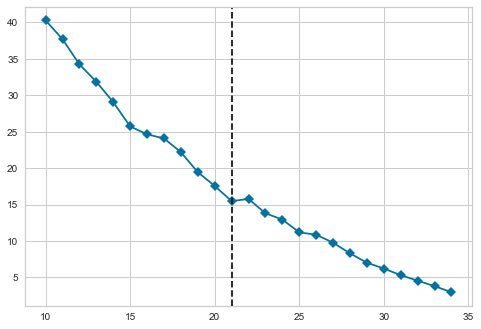

In [134]:
data_brick_novelty_ukwac_ewm_cosinedist_cluster = get_novelty_ukwac_ewm_cosinedist_cluster(data_brick, 'brick', stopwords_spacy, True, False)
data_brick_novelty_ukwac_ewm_cosinedist_cluster

## Novelty Algo 6
### ukwac_sem_space + local minima + cosine distance + clustering
### average responses cosine distance in the same cluster
### idea is that phrases with same alternate task will group
### variation in phrase in the same cluster will  be averaged out
### differs from algo 5, does local minima not ewm

In [74]:
# get df with results of the cosine distance from prompt using the elementwise multiplied vectors in the response
def get_novelty_ukwac_minimavec_cosinedist_cluster(df, prompt, stopwords_list, remove_sw, join_list):
    # clean the responses
    novel_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    novel_rating_df = novel_rating_df[novel_rating_df.astype(str)['response_processed'] != '[]']
    cleaned_responses = novel_rating_df['response_processed'].tolist()
    novel_rating_df['response_processed_phrase'] = [' '.join(x) for x in cleaned_responses]
    # list to store cosine sims
    cosine_sim_list = []

    # implement algo
    # pass in clean responses
    for response in cleaned_responses:
        # add novelty rating to list 
        cosine_sim_list.append(get_minima_vector_cos_distance(prompt, response))

    # add novelty rating list to dataframe
    novel_rating_df['minima_vector_cosine_dis'] = cosine_sim_list
        
    novel_rating_df['minima_vector_cosine_dis_clus_avg'] = get_clustered_novelty_score(novel_rating_df, 'minima_vector_cosine_dis')
    
    # new column with novelty rating
    return novel_rating_df

,id,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,response_processed,response_processed_phrase,minima_vector_cosine_dis,minima_vector_cosine_dis_clus_avg
0,1476,as a foundation,foundation,Brick,brick,0.77417,[foundation],foundation,0.936781,0.864627
1,1476,as a weapon,weapon,Brick,brick,0.85011,[weapon],weapon,0.956177,0.956177
2,1476,as a bowl,bowl,Brick,brick,0.82926,[bowl],bowl,0.779148,0.864627
3,1718,build a house,build house,Brick,brick,0.93854,"[build, house]",build house,0.609464,0.609464
4,1718,break a window,break window,Brick,brick,0.96992,"[break, window]",break window,0.905654,0.905654
5,1718,line a fireplace,line fireplace,Brick,brick,0.99511,"[line, fireplace]",line fireplace,0.801291,0.769844
6,1718,line a road,line road,Brick,brick,0.99395,"[line, road]",line road,0.801291,0.769844
7,1691,build house,build house,Brick,brick,0.93854,"[build, house]",build house,0.609464,0.609464
8,1691,break window,break window,Brick,brick,0.96992,"[break, window]",break window,0.905654,0.905654
9,1691,weight for workout,weight workout,Brick,brick,1.05438,"[weight, workout]",weight workout,1.022161,0.984955


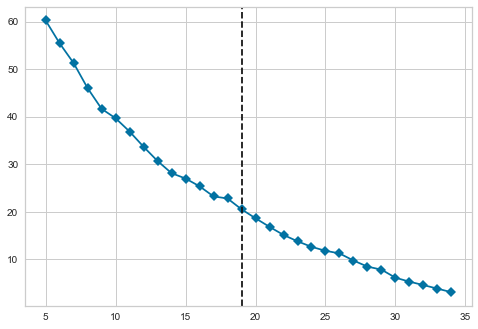

In [75]:
data_brick_novelty_ukwac_minimavec_cosinedist_cluster = get_novelty_ukwac_minimavec_cosinedist_cluster(data_brick, 'brick', stopwords_spacy, True, False)
data_brick_novelty_ukwac_minimavec_cosinedist_cluster

### Write Results into Excel Sheet

In [34]:
prompts_list = ['cup', 'key', 'rope', 'brick', 'chair', 'pencil', 'shoe']
data_list = [data_cup, data_key, data_rope, data_brick, data_chair, data_pencil, data_shoe]

In [35]:
# write results df of each dataset for specific methods
def write_results_excel(method, stopwords, model):
    # change this when writing new sheet
    writer = pd.ExcelWriter('novelty_algo_6_results.xlsx', engine='xlsxwriter')

    for i in range(len(prompts_list)):
#         df = method(data_list[i], prompts_list[i], stopwords, model, True, False)
        df = method(data_list[i], prompts_list[i], stopwords, True, False)
        df.to_excel(writer, sheet_name = prompts_list[i], index = False)
    writer.save()

In [36]:
# write_results_excel(get_novelty_word2vec_avg, stopwords_spacy, word_model_twitter25)

In [37]:
# write_results_excel(get_novelty_word2vec_sif_cosinesim, stopwords_spacy, word_model_twitter25)

In [38]:
# write_results_excel(get_novelty_ukwac_ewm_cosinedist, stopwords_spacy, word_model_twitter25)

In [39]:
# write_results_excel(get_novelty_ukwac_minimavec_cosinedist, stopwords_spacy, word_model_twitter25)

In [40]:
# write_results_excel(get_novelty_ukwac_ewm_cosinedist_cluster, stopwords_spacy, word_model_twitter25)

In [41]:
# write_results_excel(get_novelty_ukwac_minimavec_cosinedist_cluster, stopwords_spacy, word_model_twitter25)

## Correlation Test with SemDis
### Comparing the Performance of the algos I wrote to SemDis

In [121]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

cup


,SemDis_corr,pval
ewm_vector_cosine_dis,0.672293,0.0
ewm_vector_cosine_dis_clus_avg,0.680910,0.0
minima_vector_cosine_dis,0.595184,0.0
minima_vector_cosine_dis_clus_avg,0.770514,0.0


key


,SemDis_corr,pval
ewm_vector_cosine_dis,0.364158,0.0006
ewm_vector_cosine_dis_clus_avg,0.255228,0.0184
minima_vector_cosine_dis,0.389313,0.0002
minima_vector_cosine_dis_clus_avg,0.116523,0.2882


rope


,SemDis_corr,pval
ewm_vector_cosine_dis,0.485267,0.0
ewm_vector_cosine_dis_clus_avg,0.401795,0.0001
minima_vector_cosine_dis,0.240893,0.0246
minima_vector_cosine_dis_clus_avg,0.280924,0.0084


brick


,SemDis_corr,pval
ewm_vector_cosine_dis,0.723305,0.0
ewm_vector_cosine_dis_clus_avg,0.702756,0.0
minima_vector_cosine_dis,0.521825,0.0001
minima_vector_cosine_dis_clus_avg,0.445281,0.0011


chair


,SemDis_corr,pval
ewm_vector_cosine_dis,0.662825,0.0
ewm_vector_cosine_dis_clus_avg,0.682874,0.0
minima_vector_cosine_dis,0.691131,0.0
minima_vector_cosine_dis_clus_avg,0.604028,0.0


pencil


,SemDis_corr,pval
ewm_vector_cosine_dis,0.658939,0.0
ewm_vector_cosine_dis_clus_avg,0.579723,0.0
minima_vector_cosine_dis,0.536092,0.0
minima_vector_cosine_dis_clus_avg,0.416098,0.0003


shoe


,SemDis_corr,pval
ewm_vector_cosine_dis,0.588259,0.0
ewm_vector_cosine_dis_clus_avg,0.414257,0.0009
minima_vector_cosine_dis,0.146935,0.2585
minima_vector_cosine_dis_clus_avg,0.132413,0.309


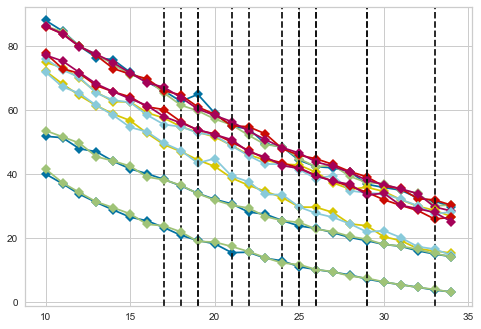

In [124]:
# print the correlations with SemDis
for i in range(len(prompts_list)):
    print(prompts_list[i])
    ewm_df = get_novelty_ukwac_ewm_cosinedist_cluster(data_list[i], prompts_list[i], stopwords_spacy, True, False)
    minima_df = get_novelty_ukwac_minimavec_cosinedist_cluster(data_list[i], prompts_list[i], stopwords_spacy, True, False)       
    concat_df = pd.concat([ewm_df, minima_df.iloc[:, 8:]], axis=1)
    concat_df = concat_df.iloc[:, [5,8,9,10,11]]
    pval_df = calculate_pvalues(concat_df)
    concat_df = concat_df.corr()
    corrs_df = pd.DataFrame(concat_df.iloc[1:, 0])
    pval_df = pd.DataFrame(pval_df.iloc[1:, 0])
    corr_pval_df = pd.concat([corrs_df, pval_df], axis=1)
    corr_pval_df.columns = ['SemDis_corr', 'pval']
    display(corr_pval_df)

Algo Design Brainstorming:
* Word2vec, average similarity between words in two responses
* Problems:
    * phrases vs words
    * compare between just two responses or the whole list of responses
* Algo Idea
    * find similarity between prompt and average of word in response
    * the average is the value that represents novelty
* Things to Look Into:
    * doc2Vec - look into sentence vector
        * follow similar logic to above but no need to average for multiple words
    * Word2Vec + SIF + Cosine Similarity
    * Word2Vec + WMD 
* Course of Actions for Missing Words/Misspellings?
    * hand remove?
* What to do when whole phrase stop words
    * make 0

* To Do List
- [x] write preprocessing methods
- [x] write out initial algo
- [x] implement first algo idea
- [x] set up work environment on macbook
- [x] look into Word2Vec + SIF + Cosine Similarity
- [x] set up excel sheet download with different sheets
- [x] use ukwac semantic space for cosine distance
- [x] set up element wise multiplied vectors for cosine distance algo
- [x] set up phrase minima vector for cosine distance algo 
- [x] Compare the ewm and phrase minima algos with SemDis
- [ ] Get a sense of the effect of the compositions
 
* Don't look into unless you have time
- [ ] look into doc2vec 
- [ ] look into Word2Vec + WMD 
- [ ] look at https://github.com/PrincetonML/SIF for better SIF 
